- Manually gen rules for amazon (sample some rows if taking too long) – just test with snorkel, no repair needed
- Create a utility to test the candidate rule accuracies 
- Test them by adding / accumulating them to see if we see improvement in global accuracy etc. Based on the results , we can see what rules from r_{gold} can the current algorithm produce. Then use r_{gold} as starting point and test via subset of rules.
- Compare r_{gold} with r_{witan}


Step 1: gen rules based on some samples:
Required components:
- A sampler to get sampled sentences from the dataset (sentence, ground truth label)
- A template for user to write
- Translate to TreeRule objects
- Test utility to gen accuracy on the dataset for this candidate LF

Step 2: given a list of rules (TreeRules), actually run with Snorkel to see the results
Required components:
- A way to specify the list of rules (could be pickle file and display user-friendly formats in order for user to specify?)
- Save the ruleset with a filename

In [29]:
# the original Amazon global accuracy with witan rules(15) is 0.64

In [30]:
from rbbm_src.labelling_func_src.src.lfs_tree import keyword_labelling_func_builder
from rbbm_src.labelling_func_src.src.TreeRules import SPAM, HAM
from rbbm_src.labelling_func_src.src.LFRepair import run_snorkel
from rbbm_src.labelling_func_src.src.classes import clean_text
import re
import pandas as pd
import psycopg2
import pandas as pd
from snorkel.labeling import (
	LabelingFunction, 
	labeling_function, 
	PandasLFApplier, 
	LFAnalysis,
	filter_unlabeled_dataframe
	)
from snorkel.labeling.model import MajorityLabelVoter, LabelModel

In [31]:
kwords_and_label_re = re.compile('\((.*)\)->(\w+)')
mapping_dict = {'negative':SPAM, 'positive':HAM}

In [32]:
def calculate_coverage(df, lf_column):
    total_instances = len(df)
    labeled_instances = df[lf_column] != -1
    coverage = labeled_instances.sum() / total_instances
    return coverage

def calculate_accuracy(df, lf_column, ground_truth_column):
    labeled_instances = df[df[lf_column] != -1]
    correct_labels = (labeled_instances[lf_column] == labeled_instances[ground_truth_column]).sum()
    total_labeled = len(labeled_instances)
    if total_labeled == 0:
        return 0.0  # Avoid division by zero if no instances are labeled
    accuracy = correct_labels / total_labeled
    return accuracy

In [33]:
conn = psycopg2.connect(dbname='label', user='postgres')

In [34]:
sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)
sentences_df = sentences_df.rename(columns={"class": "expected_label", "content": "old_text"})
sentences_df['text'] = sentences_df['old_text'].apply(lambda s: clean_text(s))
sentences_df = sentences_df[~sentences_df['text'].isna()]

/tmp/ipykernel_3228/3647735799.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sentences_df=pd.read_sql(f'SELECT * FROM amazon01', conn)


In [35]:
# individual lf accuracies on data

In [36]:
from collections import defaultdict
individual_func_stats = defaultdict(dict)

In [37]:
rules_written = ['(love,terrific,amazing)->positive',
                 '(great,helpful,five stars)->positive',
                 '(repeat customer)->positive',
                 '(beautiful, excellent)->positive',
                 '(favorite,nice)->positive',
                 '(comfortable)->positive',
                 '(one star, terrible)->negative',
                 '(broken, poor)->negative',
                 '(cheap, only)->negative'
                 '(crap,big,small)->negative',
                 '(difficult)->negative',
                 '(not, depress)->negative',
                 '(boring)->negative'
                 ]
manual_tree_rules = []

for r in rules_written:
    try:
        kword_string, label_text = kwords_and_label_re.search(r).groups()
        kwords = [x.strip() for x in kword_string.split(',')]
        label = mapping_dict[label_text.strip()]
        manual_tree_rules.append(keyword_labelling_func_builder(keywords=kwords, expected_label=label))
    except:
        print(f'not captured properly for rule {r}')
manual_funcs = [f.gen_label_rule() for f in manual_tree_rules]

for f in manual_funcs:
    print(f)
    sentences_df['lf_labeled'] = sentences_df.apply(f, axis=1)
    cov=calculate_coverage(df=sentences_df, lf_column='lf_labeled')
    acc=calculate_accuracy(df=sentences_df, lf_column='lf_labeled', ground_truth_column='expected_label')
    individual_func_stats[f]={'cov':cov, 'acc':acc}
    print(f"cov:{round(cov,4)}, acc:{round(acc,4)}")
    print('---------------------------------------\n')

PredicateNode(id=1, pred=keyword_predicate-word-(love,terrific,amazing))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.1854, acc:0.8075
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(great,helpful,five stars))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.3081, acc:0.8674
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(repeat customer))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0001, acc:0.5
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(beautiful,excellent))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0515, acc:0.856
---------------------------------------

PredicateNode(id=1, pred=keyword_predicate-word-(favorite,nice))
    LabelNode(id=2, label=-1)
    LabelNode(id=3, label=0)
cov:0.0752, acc:0.7812
---------------------------------------

PredicateNode(id=1, pred=keyword_pred

In [38]:
exclude_strings_positive = ['love','terrific','amazing', 
                   'great','helpful','five stars',
                   'repeat customer', 'beautiful', 
                   'excellent', 'favorite'
                  ]

# Create a regex pattern to match any of the exclude_strings
pattern_positive = '|'.join(exclude_strings_positive)

In [39]:
exclude_strings_negative = ['one star', 'terrible', 'broken']

# Create a regex pattern to match any of the exclude_strings
pattern_negative = '|'.join(exclude_strings_negative)

In [40]:
sentences_df[(~sentences_df['text'].str.contains(pattern_positive, na=False))&
            (sentences_df['expected_label']==HAM)][['text','expected_label']].sample(10)

,text,expected_label
19247,buy these if you intend on removing door trims these clips worked well for reinstalling my door trims in my e46 if you are careful when removing the door trims and dont break all of them you will have enough there are a total of 16 clips in a sedan also unlike the dash clips these are reusable so you can remove the trim again if you need togiven the plastic hasnt degraded from heat and age,0
4983,i am so happy to have these particular filters water tastes so clean i can taste the difference i am so happy to have these particular filters so happy with my system,0
8230,had to finish it quickly this was fast paced and well written the issues were handled well using flashbacks and dreams to fill in the reader i liked and loathed the characters accordingly and was driven to find out the whole truth even when i suspected much of it this was not heavy handed like it couldve been nor was it the kind of book where you just want to smack the protagonist for her whining and stupid choices she was believably sincere unsure of herself ashamed and even brave the author portrayed the characters and the situations believably through to the end,0
19056,good price high quality perfect match yes it did meet expects super wow speaker now i need a bigger one for my house but please tell me how to disassemble the speaker cuz its not making any sounds after some use and i need to fix it,0
10669,a real find like a wind through hollow bones is a superlative book that is impossible to put down both the narrative and the writing are outstanding i look forward to the next two books in the trilogy,0
7084,the literary lottery where art meets commerce martha mcphee is the real deal her novel is engrossing intelligent playful and timely and it would be a shame if it did not get the high readership it deserves\n\nin this pygmalion tale of novelist turned bond trader india palmer is well very much like the author herself shes a critically acclaimed writer of four books and has just completed her fifth she and her husband a gifted but not so rich sculptor are close friends with a wealthy couple who live luxuriously in nycs tony tribeca area in indias attempt to keep up with the joneses she discovers that one goes broke in a thousand small ways birthday presents house presents ballet classes lessons in general theater subscriptionsdinners out\n\nwhen a friend of her affluent friends a rakish financier propositions her with the promise that in eighteen months hell make her a world class bond trader she jumps she realizes that she cannot make her way in a bankers world on a writers budget and so she turns her back on the world of serious art and embraces the adrenalin pumping world of the trade\n\nms mcphee writes i had wanted to see if it was possible to change the course of my life in a way i had wanted to confirm be erased be reborn to live the american dream the transformation is fascinating and if the book focused on just that it would have needed little more\n\nbut the author goes further dear money provides fascinating inside glimpses on how the publishing instant celebrity culture ensures that an it writer a total newbee can rise to the top faster than an author with a solid track record it reveals a fascinating analogy between traders and publishers take a bunch of aspiring writers earning nothing subprime mortgages pool them put them in a nifty package with bells and whistles offer it up for trade and make moneyloads and loads of it\n\ncan writers or traders afford to compromise what would compromise feel like ms mcphee writes to leave now to scale back to compromise would be to live within a shadow of regret of second guessing of exile this timely american story of our culture on the brink kept me reading way into the night and in a strange way cheering for india palmer read it and enjoy,0
4635,looks good and looks to last too we picked this up as part of a facelift of our front porch i have to admit i was a bit skeptical at f

In [41]:
sentences_df[(~sentences_df['text'].str.contains(pattern_negative, na=False))&
            (sentences_df['expected_label']==SPAM)][['text','expected_label']].sample(10)

,text,expected_label
6973,20 page ink longevity called epson says designed that way included cartridges for priming not printing they say ok its a descent printer i wanted it for its air print feature so my ipad can print to it none of the ipad apps work well so i wanted this and it works flawlessly i have four epson printers from this one to an artisan 710 and the workforce series it seems like all of them do one thing well leaving something lacking the pain in the butt on this one is the paper feed trays are not only confusing but are small the printer wont print pictures to regular paper tray without some hokus pocus that i cant figure out you must use the photo paper tray that has all these settings and guides you must align the other epsons work easier but dont print quite as good a quality photos except the artisan is as good\n\nthe touch screen is awesome a must have feature no more clicking through ten menues to get to where you need to be to change a setting\n\none of the strangest features is extending print guide watch the video and you will see it i like the printer but it does have its flaws i would not buy it again it is such a departure in design and function from previous epsons its just odd\n\nupdate\nink cartridges are very small smallest i have seen on any printer ran out after twenty pages printer shuts down and will not print after it gets a signal of low ink\ni have contacted epson about this problem they replied cartridges only intended to prime ink heads not to print need another set of cartridges to print would you like to order some from me now uhhh no,1
8122,do not buy ebook i purchased ebook thinking it would be easier to read here and there on my various electronic devices problem is my prof assigns by page number and skips around for example read pages 78 99 pg 103 then 110 114 the ebook does not have page numbers so now i have to buy the paper back version as well ive now spent close to 200 on a book that should have cost 92,1
10901,color problem the pant its very good but they didnt send me the color that i bought the antique indigo look different,1
19505,way too large i order shoes on line all the time and always order a 10 and they always fit of course todays 10 is what used to be a 9 ive measured 10s beside my 9s and they are the same size however when i measured these they measure 11 inches from inside the toe to inside the heel they are not sized correctly however amazon made it super easy for me to return these and debited my card immediately i like the shoes but am now afraid to risk ordering another size,1
14702,i thought these would be fun to have as glasses to wear while doing things i thought these would be fun to have as glasses to wear while doing things i didnt want to scratch up my nice glasses the quality is poor but i guess if you wanted them for a costume or something they could work i wish i didnt buy them at least they were cheap though,1
16837,way too thin i definitely will not wear these in public you can see straight through them terribly thin material they are completely baggy and shapeless i will avoid the hassle of sending them back only because i can wear them as pajamas,1
18880,failed drive has failed my cash was working fine but like so many other reviewers have pointed out it died in about 3 months\nvery little warning blue screen and now boom tested drive in another pc and the drive is just dead,1
15759,terrific contents poor printing i will not elaborate on the contents of j r r tolkiens masterpiece others have done that much better just read some the remaining reviews instead i would like to give my two cents to this specific edition while it is dubbed as collectors edition i had to find out the hard way that it is not really set in new type but only photo offset from another edition which leads to an irregular print with lots of flaws in the appearance of the different letters if you know the book just compare pages 6 photo offset and 7 conventionally set for ex

In [42]:
sentences_df[sentences_df['text'].str.contains('not', na=False)].groupby('expected_label').size()

expected_label
0    2190
1    5532
dtype: int64

In [43]:
applier = PandasLFApplier(lfs=manual_funcs)
initial_vectors = applier.apply(df=sentences_df, progress_bar=False)
model = LabelModel(cardinality=2, verbose=True, device='cpu')
model.fit(L_train=initial_vectors, n_epochs=500, log_freq=100, seed=123)

probs_test= model.predict_proba(L=initial_vectors)


INFO 2024-08-05 04:23:47,141 [label_model.py:fit:905] Computing O...
INFO 2024-08-05 04:23:47,147 [label_model.py:fit:911] Estimating \mu...
 38%|███████████████████▉                                | 192/500 [00:00<00:00, 601.01epoch/s]INFO 2024-08-05 04:23:47,581 [logger.py:log:79] [200 epochs]: TRAIN:[loss=0.001]
INFO 2024-08-05 04:23:47,661 [logger.py:log:79] [300 epochs]: TRAIN:[loss=0.001]
100%|████████████████████████████████████████████████████| 500/500 [00:00<00:00, 741.19epoch/s]
INFO 2024-08-05 04:23:47,826 [label_model.py:fit:977] Finished Training


In [44]:
# import importlib

# # Determine the module name
# module_name = filter_unlabeled_dataframe.__module__

# # Import the module by name
# module = importlib.import_module(module_name)

# # Print the file path of the module
# print(module.__file__)

In [45]:
df_sentences_filtered, probs_test_filtered, filtered_vectors, df_no_signal = filter_unlabeled_dataframe(
        X=sentences_df, y=probs_test, L=initial_vectors
)

df_sentences_filtered = df_sentences_filtered.reset_index(drop=True)
prob_diffs = [abs(t[0]-t[1]) for t in probs_test_filtered]
prob_diffs_tuples = [(t[0],t[1]) for t in probs_test_filtered]
df_sentences_filtered['model_pred_diff'] = pd.Series(prob_diffs)
df_sentences_filtered['model_pred_prob_tuple'] = pd.Series(prob_diffs_tuples)
df_sentences_filtered['model_pred'] = pd.Series(model.predict(L=filtered_vectors))

wrong_preds = df_sentences_filtered[(df_sentences_filtered['expected_label']!=df_sentences_filtered['model_pred'])]

accuracy=(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)

print(f"""
    out of {len(sentences_df)} sentences, {len(df_sentences_filtered)} actually got at least one signal to \n
    make prediction. Out of all the valid predictions, we have {len(wrong_preds)} wrong predictions, \n
    accuracy = {(len(df_sentences_filtered)-len(wrong_preds))/len(df_sentences_filtered)} 
    """)


    out of 19946 sentences, 16494 actually got at least one signal to 

    make prediction. Out of all the valid predictions, we have 2324 wrong predictions, 

    accuracy = 0.8591002788892931 
    


In [46]:
len(df_sentences_filtered)

16494

In [47]:
# len(df_no_signal)

In [48]:
df_no_signal[['text','expected_label']][df_no_signal['expected_label']==SPAM].sample(10)

,text,expected_label
6972,spice carousel after a year of dealing with this thing i am so ready to trash it i bought 2 to stack and have put up with having to glue the front of the canisters on them constantly falling out of the carousel causing me to have to clean up the mess way too many times they dont pour sprinkle out the spices well and im sure could come up with more flaws but i need to search for a better spice organizer instead of wasting my time bashing this awful frustrating product,1
9993,the worst quality im afraid to say the quality of the film is awful blurry grainy and the characters are cut off on both sides of the film if its in color its totally washed out as is the sound track also there was no cover art just a printed label im traveling at the moment but plan on returning the sword and the dragon when i return home,1
12723,has a known defect on windows 7 doubles the letters s and l go figure has a defect at least on windows 7 where letter ss and ls tend to get doubled regardless of the keyboard driver settings researched this on the logitech boards and yes its a known issue with no fix i was able to minimize the problem by adjusting my keyboard driver sensitivity but i still need to be extra careful when typing fast ive kept it because i do like the mouse and the low profile receiver that i can keep plugged into my laptop all the time,1
10457,too silly too silly to be enjoyed,1
17494,the worst quality ever the worst quality ever the metal holder for the popsicle came damaged the color is cracked and was peeling off,1
14068,horrible return policy horrible return policy ive never had to pay for return shipping with amazon before also they deduct up to 70 based on the time elapsed between purchase and return i purchased these as a gift and now can only hope to receive 30 of the purchase price minus the return shipping maybe ill just keep these and hope she gains weight and they fit,1
19737,disapointed in amazons care for these items i wanted this pop vinyl because he was an exclusive but when i received it the box was damaged and scratched very disappointed,1
12308,nah never worked to stop spraying i got some spray by martha stewart for s fraction of the price that smelled better and actually worked,1
18796,lots of glue on hair line this wig was horrible i received it with caked on glue starting from the front hair line towards the back,1
19451,more trouble than its worth very underpowered and will get you in more trouble than it will possibly save you time wise i took a well charged tool to the lumber yard to cut soem pine trim down to size to fit in a car after 3 4 cuts in pine baseboards it started to bog and bind and die,1


In [49]:
# Analyze the labels
analysis = LFAnalysis(L=initial_vectors, lfs=manual_funcs)
analysis.lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
"PredicateNode(id=1, pred=keyword_predicate-word-(love,terrific,amazing))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",0,[0],0.185401,0.140028,0.079314
"PredicateNode(id=1, pred=keyword_predicate-word-(great,helpful,five stars))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",1,[0],0.308082,0.167603,0.090544
"PredicateNode(id=1, pred=keyword_predicate-word-(repeat customer))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",2,[0],0.000100,0.000100,0.000050
"PredicateNode(id=1, pred=keyword_predicate-word-(beautiful,excellent))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",3,[0],0.051539,0.041612,0.022360
"PredicateNode(id=1, pred=keyword_predicate-word-(favorite,nice))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",4,[0],0.075153,0.061666,0.036950
"PredicateNode(id=1, pred=keyword_predicate-word-(comfortable))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=0)",5,[0],0.028126,0.023764,0.013135
"PredicateNode(id=1, pred=keyword_predicate-word-(one star,terrible))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",6,[1],0.098566,0.053595,0.011230
"PredicateNode(id=1, pred=keyword_predicate-word-(broken,poor))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",7,[1],0.047578,0.038404,0.014439
"PredicateNode(id=1, pred=keyword_predicate-word-(cheap,only)->negative(crap,big,small))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",8,[1],0.133861,0.106488,0.053344
"PredicateNode(id=1, pred=keyword_predicate-word-(difficult))\n LabelNode(id=2, label=-1)\n LabelNode(id=3, label=1)",9,[1],0.014439,0.012183,0.006217


In [50]:
lf_vectors = filtered_vectors
ground_truth = df_sentences_filtered['expected_label']
snorkel_predictions = df_sentences_filtered['model_pred']

DEBUG 2024-08-05 10:47:34,463 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:34,465 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
DEBUG 2024-08-05 10:47:34,477 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:34,478 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+0

DEBUG 2024-08-05 10:47:34,884 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:34,885 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
DEBUG 2024-08-05 10:47:34,990 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:34,991 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
DEBUG 2024-08-05 10:47:34,993 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:34,994 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+0

DEBUG 2024-08-05 10:47:35,279 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:35,280 [ticker.py:tick_values:2433] ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06])
DEBUG 2024-08-05 10:47:35,282 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:35,283 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+0

DEBUG 2024-08-05 10:47:35,447 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:35,448 [ticker.py:tick_values:2433] ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06])
DEBUG 2024-08-05 10:47:35,450 [ticker.py:tick_values:2375] vmin 0.634065327181051 vmax 14295.057009814798
DEBUG 2024-08-05 10:47:35,451 [ticker.py:tick_values:2433] ticklocs array([1.e-0

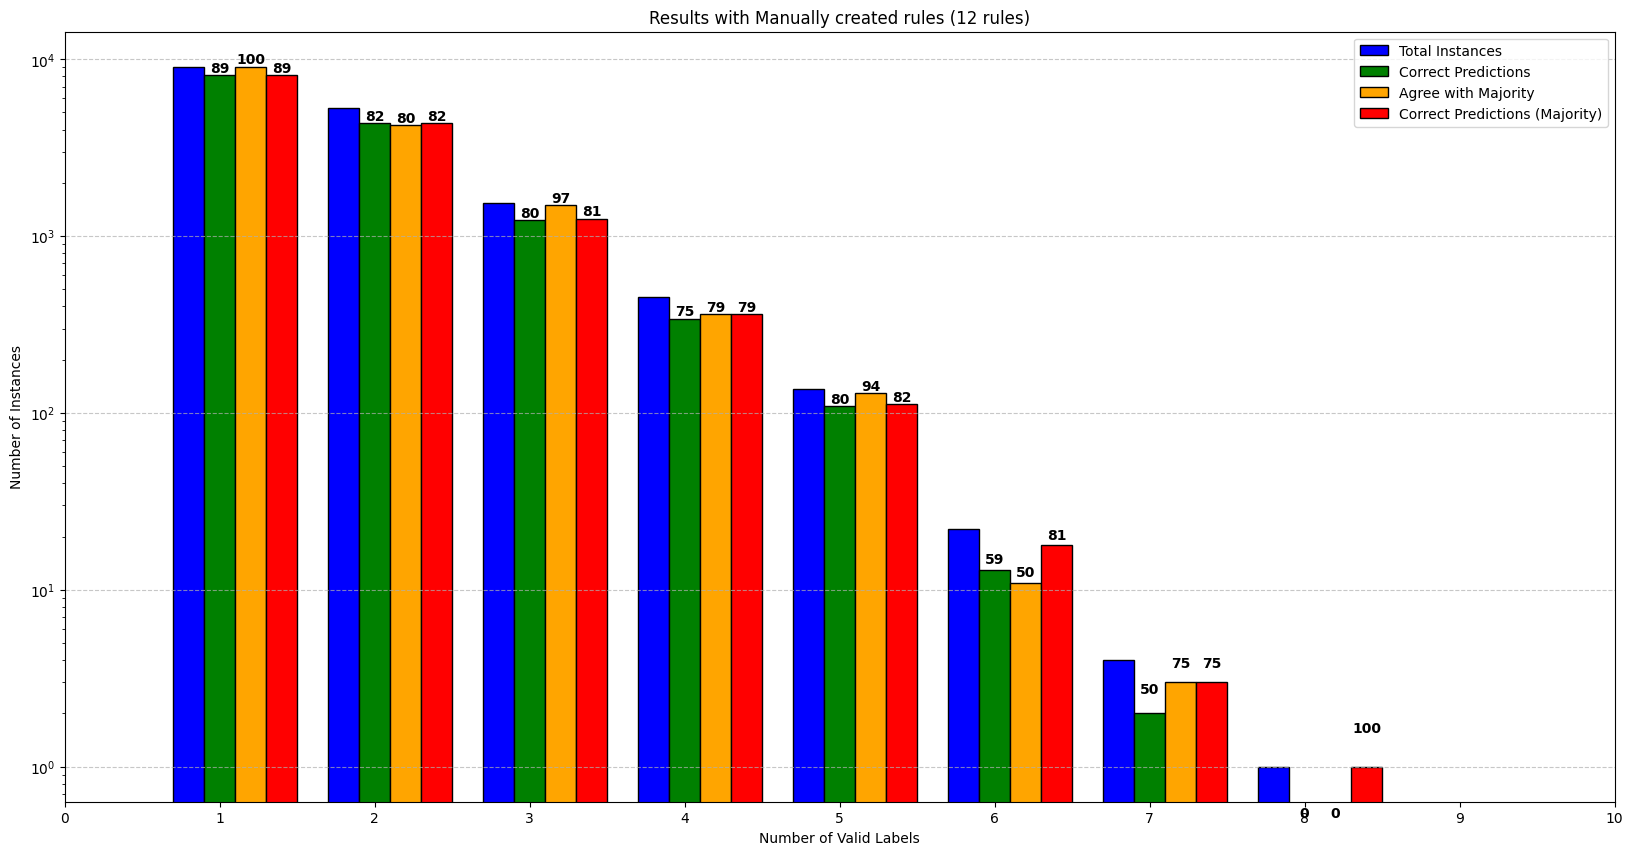

In [66]:

from collections import Counter


# Define the abstain label
abstain_label = -1

# Calculate the majority vote for each instance
def majority_vote(labels):
    valid_labels = [label for label in labels if label != abstain_label]
    if valid_labels:
        return Counter(valid_labels).most_common(1)[0][0]
    else:
        return abstain_label

majority_votes = np.array([majority_vote(row) for row in lf_vectors])

# Count the number of valid (non-abstain) labels for each instance
valid_label_counts = np.sum(lf_vectors != abstain_label, axis=1)

# Determine the number of correct Snorkel predictions
correct_predictions = (snorkel_predictions == ground_truth)

# Determine the number of Snorkel predictions that agree with the majority vote
agree_with_majority = (snorkel_predictions == majority_votes)

# correct majority results
correct_majority_predictions = (majority_votes == ground_truth)

# Count the total instances, correct predictions, and agreements with majority vote for each number of valid labels
max_valid_labels = 27
total_counts = Counter(valid_label_counts)
correct_counts = Counter(valid_label_counts[correct_predictions])
agree_counts = Counter(valid_label_counts[agree_with_majority])
correct_majority_counts = Counter(valid_label_counts[correct_majority_predictions])


# Prepare data for plotting
x = np.arange(max_valid_labels + 1)
total_instances = np.array([total_counts[i] for i in x])
correct_instances = np.array([correct_counts[i] for i in x])
agree_instances = np.array([agree_counts[i] for i in x])
correct_majority_instances = np.array([correct_majority_counts[i] for i in x])


# Calculate the ratio for annotations
ratios_correct = np.divide(correct_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_agree = np.divide(agree_instances, total_instances, out=np.zeros_like(correct_instances, dtype=float), where=total_instances != 0)
ratios_correct_majority = np.divide(correct_majority_instances, total_instances, out=np.zeros_like(correct_majority_instances, dtype=float), where=total_instances != 0)


plt.figure(figsize=(20, 10))
bar_width = 0.2
total_bars = plt.bar(x - bar_width, total_instances, bar_width, label='Total Instances', color='blue', edgecolor='black')
correct_bars = plt.bar(x, correct_instances, bar_width, label='Correct Predictions', color='green', edgecolor='black')
agree_bars = plt.bar(x + bar_width, agree_instances, bar_width, label='Agree with Majority', color='orange', edgecolor='black')
correct_majority_bars = plt.bar(x + 2 * bar_width, correct_majority_instances, bar_width, label='Correct Predictions (Majority)', color='red', edgecolor='black')


plt.xlabel('Number of Valid Labels')
plt.ylabel('Number of Instances')
plt.title('Results with Manually created rules (12 rules)')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Limit the x-axis range
plt.xlim(0, 10)  # Adjust the range as needed
plt.yscale('log')
# Add annotations for the ratios
# Add annotations for the ratios
for i in range(len(x)):
    if total_instances[i] > 0:  # Only add text if there are instances
        plt.text(x[i], correct_instances[i] + 0.5, f'{int(ratios_correct[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.text(x[i] + bar_width, agree_instances[i] + 0.5, f'{int(ratios_agree[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        plt.text(x[i] + 2 * bar_width, correct_majority_instances[i] + 0.5, f'{int(ratios_correct_majority[i]*100)}', ha='center', va='bottom', fontweight='bold', fontsize=10, color='black')
plt.savefig('distribution_of_labels_manual_rules_only.pdf', format='pdf')
plt.show()



In [69]:
correct_majority_instances

array([   0, 8131, 4329, 1256,  361,  112,   18,    3,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [70]:
correct_majority_counts

Counter({1: 8131, 2: 4329, 3: 1256, 4: 361, 5: 112, 6: 18, 7: 3, 8: 1})

In [71]:
sum([v for v in correct_majority_counts.values()])

14211

In [72]:
lf_vectors.shape

(16494, 12)

In [73]:
14211/16494

0.8615860312841033